# Setup

In [1]:
import contracts
contracts.disable_all()

In [2]:
import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_html
import geometry as g
import numpy as np
import networkx as nx

INFO:dt-world:duckietown-world 1.0.15
DEBUG:dt-serialization:Registering class Serializable
DEBUG:dt-serialization:Registering class GenericData
DEBUG:dt-serialization:Registering class Sequence
DEBUG:dt-serialization:Registering class SampledSequence
DEBUG:dt-serialization:Registering class Constant
DEBUG:dt-serialization:Registering class RectangularArea
DEBUG:dt-serialization:Registering class TransformSequence
DEBUG:dt-serialization:Registering class VariableTransformSequence
DEBUG:dt-serialization:Registering class SE2Transform
DEBUG:dt-serialization:Registering class Scale2D
DEBUG:dt-serialization:Registering class Matrix2D
DEBUG:dt-serialization:Registering class SpatialRelation
DEBUG:dt-serialization:Registering class GroundTruth
DEBUG:dt-serialization:Registering class PlacedObject
DEBUG:dt-serialization:Registering class EvaluatedMetric
DEBUG:dt-serialization:Registering class GenericObject
DEBUG:dt-serialization:Registering class Duckie
DEBUG:dt-serialization:Registering cla

In [3]:
dw.logger.setLevel(50)

Better visualization of output

In [4]:
%%html
<style>
pre {line-height: 90%}
</style>

# Road Network
Let's load a map and compute the road network.

In [25]:
m = dw.load_map('4way')


Use the function `get_skeleton_graph`:

In [26]:
sk = dw.get_skeleton_graph(m)

The return type is `SkeletonGraphResult`. It contains in `sk.root2` a new map with the joined lane segments. 

In [27]:
ipython_draw_html(sk.root2);

While in the attribute `sk.G` we find a graph describing the topology.

This is a graph where each node is a meeting point between lanes, and each edge represents a lane.

In [28]:
import sys
sys.path.append("/home/jose/code/duckietown/duckietown-uplan/lib-uplan/")
import utils.augmentation as aug

aug_graph = aug.augment_graph(sk.G)

Let's bring in the `draw_graph` function from some time ago.

In [29]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={}, node_size=10) # node:node for node in G0.nodes()
    nx.draw_networkx_edge_labels(G0,pos,edge_labels={},font_color='red')
    plt.axis('off')
    plt.show()

Set the position of each node in the graph based on the attribute 'point'.

In [30]:
%matplotlib inline

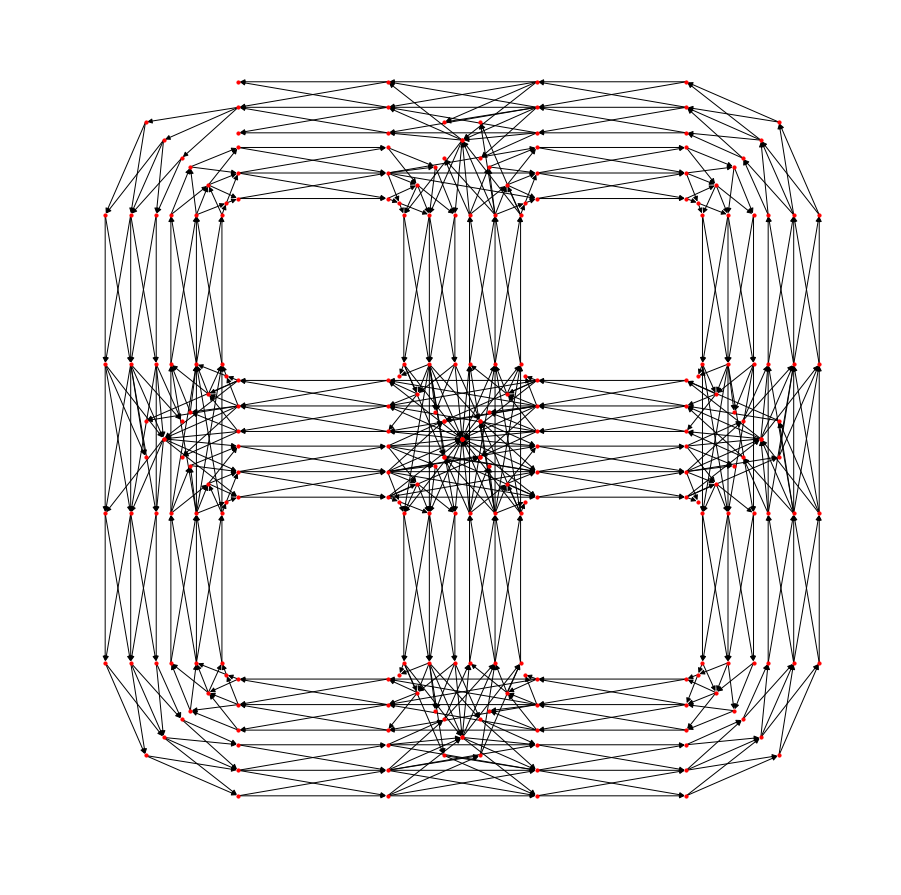

In [31]:
import geometry as geo
pos = {}
for n in aug_graph:
    q = aug_graph.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(aug_graph, pos=pos)

## Planning example

Here is an example of how to do planning on the road network.

We select a start and end node:

In [ ]:
start = 'P60'
end = 'P36'

We find the shortest path:

In [ ]:
import networkx as nx
path = nx.shortest_path(sk.G, start, end)
print(path)

We retrieve the edge names:

In [ ]:
def get_lanes(path):
    edges = zip(path[:-1], path[1:]) 
    lanes  = []
    for a, b in edges:
        lane = sk.G.get_edge_data(a, b)[0]['lane']
        lanes.append(lane)
    return lanes

In [ ]:
lanes = get_lanes(path);
print(lanes)

For visualization, we create a new map containing only the lanes selected: 

In [ ]:
po = dw.PlacedObject()
for lane_name in lanes:
    lane = sk.root2.children[lane_name]
    po.set_object(lane_name, lane, ground_truth=dw.SE2Transform.identity())

In [ ]:
ipython_draw_html(po);